In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
import pandas as pd
import os
from PIL import Image
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import math

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:

root = '/content/drive/MyDrive/Colab Notebooks/Dataset/CATS_DOGS/'
#Image folder
train_data = datasets.ImageFolder(os.path.join(root,'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test'), transform=test_transform)

torch.manual_seed(42)

#data loader
train_loader = DataLoader(train_data, batch_size=10, shuffle= True)
test_loader = DataLoader(test_data, batch_size=10,shuffle=True)

class_names = train_data.classes


In [7]:
train_data

Dataset ImageFolder
    Number of datapoints: 18753
    Root location: /content/drive/MyDrive/Colab Notebooks/Dataset/CATS_DOGS/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
len(train_data)

18753

In [ ]:
len(test_data)

6260

In [ ]:
for images, labels in train_loader:
  break

In [ ]:
images.shape

torch.Size([10, 3, 224, 224])

In [ ]:
labels

tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1])

Label: [0 0 1 1 1 0 0 0 0 1]
Class: CAT CAT DOG DOG DOG CAT CAT CAT CAT DOG


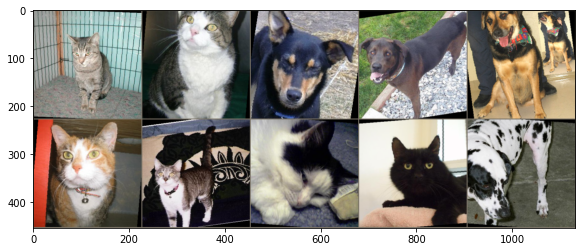

In [ ]:
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow = 5)
inv_normalized = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225], 
                                      std=[1/0.229,1/0.224,1/0.225])
im_inv = inv_normalized(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # In Channels -> 3 
        # Out channels -> 6
        # Filter -> 3x3
        # Stride -> 1
        self.conv1 = nn.Conv2d(3,6,3,1)

        # In Channels -> 6 
        # Out channels -> 16
        # Filter -> 3x3
        # Stride -> 1
        self.conv2 = nn.Conv2d(6,16,3,1)

        #math.floor((((224-2)/2)-2)/2) = 54
        self.fc1 = nn.Linear(54*54*16,120) 
        self.fc2 = nn.Linear(120,84) 
        self.fc3 = nn.Linear(84,2)
    
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(101)

#Hyper parameters
LEARNING_RATE = 0.001
EPOCHS = 3

#CNN Model
model = ConvNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)


In [ ]:
model

ConvNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
total_params = 0
for parameters in model.parameters():
  print(parameters.numel())
  total_params += parameters.numel()

162
6
864
16
5598720
120
10080
84
168
2


In [ ]:
print(f"Total params: {total_params/1000000} mil")

Total params: 5.610222 mil


In [ ]:
import time
start_time = time.time()

#Limiting batch sizes
max_trn_batch = 800 #batch 10 images -> 8000 images
max_tst_batch = 300 #3000 max images

train_losses = []
test_losses = []
train_correct = []
test_correct = []


for i in range(EPOCHS):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
      #Limiting batch sizes for testing the model
      if( b==max_trn_batch):
        break
      
      b+=1
      y_pred = model(X_train)
      loss = criterion(y_pred, y_train) #Loss calculation

      #Storing #correct predictions
      predicted = torch.max(y_pred.data,1)[1]
      batch_corr = (predicted == y_train).sum()
      trn_corr += batch_corr

      #Backprop -> updating parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (b%200 ==0):
        print(f"Epoch:{i}, Loss: {loss.item()} ")
      
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
          if( b==max_tst_batch):
            break
          y_test_pred = model(X_test)
          predicted = torch.max(y_test_pred.data,1)[1]           
          tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_test_pred, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {total_time/60} mins')

Epoch:0, Loss: 0.6418389081954956 
Epoch:0, Loss: 0.661040723323822 
Epoch:0, Loss: 0.5951164960861206 
Epoch:0, Loss: 0.6387826204299927 
Epoch:1, Loss: 0.4089294970035553 
Epoch:1, Loss: 0.4013349413871765 
Epoch:1, Loss: 0.32978057861328125 
Epoch:1, Loss: 0.41428470611572266 
Epoch:2, Loss: 0.4459303319454193 
Epoch:2, Loss: 0.5299496054649353 
Epoch:2, Loss: 0.5518704056739807 
Epoch:2, Loss: 0.3561515808105469 
Time taken: 59.58967864513397 mins


In [ ]:
torch.save(model.state_dict,'/content/drive/MyDrive/Colab Notebooks/Models/cat_dog_epoch3.pt')

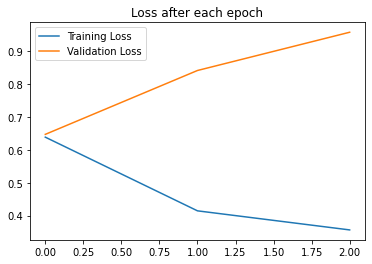

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.title("Loss after each epoch")
plt.legend()

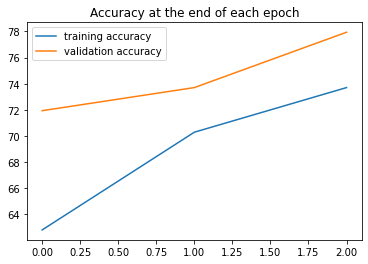

In [ ]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [ ]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2158), tensor(2211), tensor(2338)]
Test accuracy: 77.933%
